Creating RawArray with float64 data, n_channels=5, n_times=46080
    Range : 0 ... 46079 =      0.000 ...   179.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 769 original time points ...
1 bad epochs dropped


C:\Users\bortn\AppData\Local\Temp\ipykernel_46380\1755981205.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  covariances = calculate_covariances(epochs.get_data())


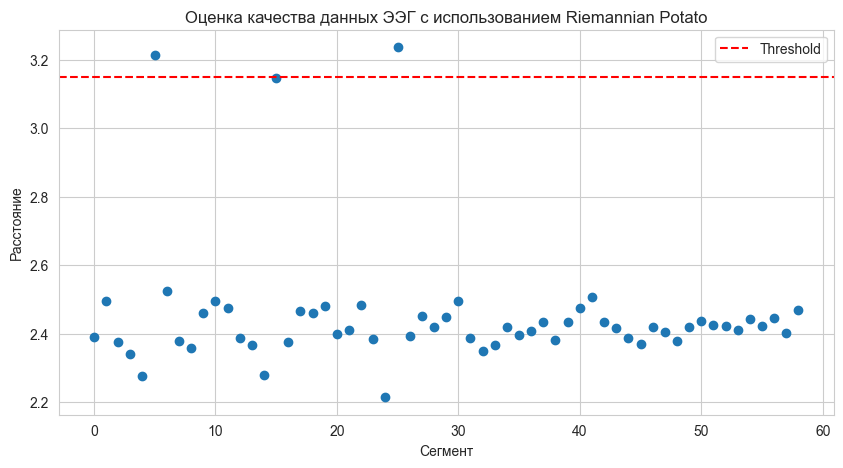

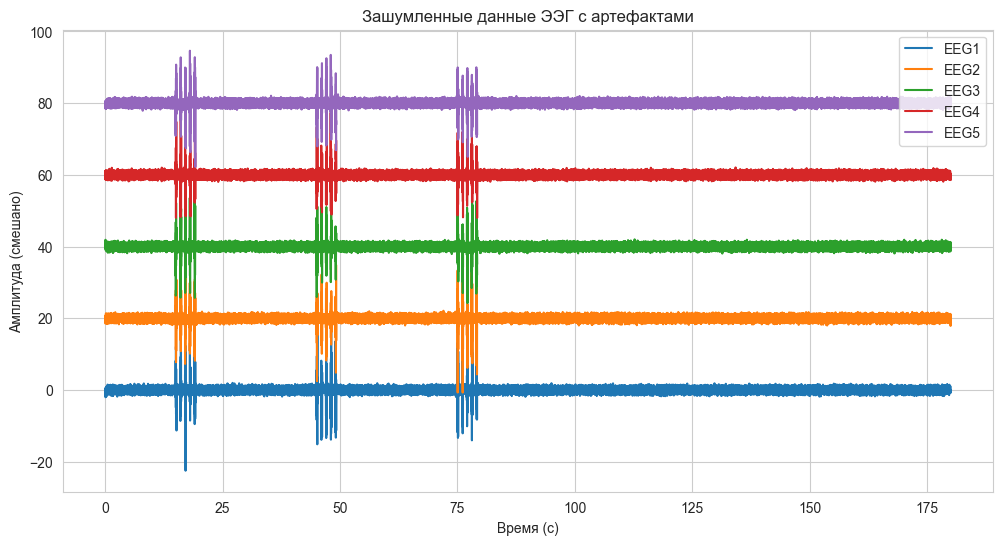

In [3]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Параметры данных
sfreq = 256  # Частота дискретизации
times = np.arange(0, 180, 1/sfreq)  # 180 секунд
n_channels = 5  # Количество каналов
n_samples = len(times)

# Генерация синусоидальных сигналов с шумом
freqs = np.array([10, 15, 20, 25, 30])  # Частоты сигналов для каждого канала
signals = np.array([np.sin(2 * np.pi * freq * times) for freq in freqs])
noise = np.random.normal(0, 0.5, signals.shape)
eeg_data = signals + noise

# Добавление артефактов (импульсы высоких амплитуд)
for i in range(15, 20):
    eeg_data[:, i * sfreq:(i * sfreq + 50)] += np.random.normal(0, 10, (n_channels, 50))

for i in range(45, 50):
    eeg_data[:, i * sfreq:(i * sfreq + 50)] += np.random.normal(0, 10, (n_channels, 50))

for i in range(75, 80):
    eeg_data[:, i * sfreq:(i * sfreq + 50)] += np.random.normal(0, 10, (n_channels, 50))

# Создание объекта RawArray в MNE
info = mne.create_info(ch_names=[f'EEG{i+1}' for i in range(n_channels)], sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)

# Шаг 1: Фильтрация данных
raw.filter(1., 40.)

# Шаг 2: Разделение данных на эпохи
events = mne.make_fixed_length_events(raw, id=1, duration=3.0)
epochs = mne.Epochs(raw, events, event_id=1, tmin=0, tmax=3.0, baseline=None, preload=True)

# Шаг 3: Вычисление ковариационных матриц
def calculate_covariances(epochs):
    n_epochs, n_channels, n_samples = epochs.shape
    covariances = np.zeros((n_epochs, n_channels, n_channels))
    for i in range(n_epochs):
        covariances[i] = np.cov(epochs[i])
    return covariances

covariances = calculate_covariances(epochs.get_data())

# Функция для вычисления риманова расстояния
def riemannian_distance(C1, C2):
    eigvals = eigh(C1, C2, eigvals_only=True)
    return np.sqrt(np.sum(np.log(eigvals) ** 2))

# Шаг 4: Обучение Riemannian Potato
def train_potato(covariances, n_train=20):
    mean_cov = np.mean(covariances[:n_train], axis=0)
    distances = np.array([riemannian_distance(mean_cov, cov) for cov in covariances[:n_train]])
    threshold = np.percentile(distances, 95)  # Установим порог на уровне 95-го перцентиля
    return mean_cov, threshold

mean_cov, threshold = train_potato(covariances)

# Шаг 5: Оценка качества новых данных
def evaluate_potato(covariances, mean_cov, threshold):
    distances = np.array([riemannian_distance(mean_cov, cov) for cov in covariances])
    predictions = distances < threshold
    return predictions, distances

predictions, distances = evaluate_potato(covariances, mean_cov, threshold)

# Шаг 6: Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(distances, 'o')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Сегмент')
plt.ylabel('Расстояние')
plt.title('Оценка качества данных ЭЭГ с использованием Riemannian Potato')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for i in range(n_channels):
    plt.plot(times, eeg_data[i] + i * 20, label=f'EEG{i+1}')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда (смешано)')
plt.title('Зашумленные данные ЭЭГ с артефактами')
plt.legend(loc='upper right')
plt.show()
